In [46]:
import sys
import os
import tensorflow as tf

# Aggiunge la cartella src al path per poter importare i moduli
sys.path.append(os.path.abspath("src"))

# Autoreload per ricaricare i moduli se li modifichi durante lo sviluppo
%load_ext autoreload
%autoreload 2

# Import dei tuoi moduli custom
from data_loader import QuantumDataManager
from quantum_transformer import QuantumTransformer
from curriculum import CurriculumLearning
from utils import ExperimentManager 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
TRANSFORMER_CONFIGS = [
    {
        "name": "transformer_small",
        "window_size": 12,
        "forecast_horizon": 12,
        "embed_dim": 64,
        "num_heads": 4,
        "ff_dim": 128,
        "num_layers": 2,
        "dropout": 0.1,
        "learning_rate": 0.0005,
        "batch_size": 32,
        "total_epochs": 20,
        "tf_epochs": 5,
        "mm_epochs": 5,
        "nr_epochs": 10
    },
    {
        "name": "transformer_medium",
        "window_size": 15,
        "forecast_horizon": 15,
        "embed_dim": 64,
        "num_heads": 8,
        "ff_dim": 256,
        "num_layers": 2,          
        "dropout": 0.15,
        "learning_rate": 0.0003,
        "batch_size": 64,
        "total_epochs": 30,
        "tf_epochs": 8,
        "mm_epochs": 0,
        "ss_epochs": 22
    },
    {
        "name": "transformer_large",
        "window_size": 15,
        "forecast_horizon": 1,
        "embed_dim": 64,
        "num_heads": 4,
        "ff_dim": 256,
        "num_layers": 2,
        "dropout": 0.2,
        "learning_rate": 0.0005,
        "batch_size": 64,
        "total_epochs": 12,
        "tf_epochs": 5,
        "mm_epochs": 5,
        "nr_epochs": 2
    }
]

In [ ]:
def train_with_curriculum(
    model,
    train_ds,
    val_ds,
    optimizer,
    loss_fn,
    epochs,
    tf_epochs,
    mm_epochs,
    nr_epochs
):
    curriculum = CurriculumLearning(model, optimizer, loss_fn)

    history = {
        "loss": [],
        "val_loss": [],
        "phase": []
    }
    

    # Totale epoche attese (utile per sanity check)
    total_epochs_calc = tf_epochs + mm_epochs + nr_epochs
    assert total_epochs_calc == epochs, (
        f"Errore: il totale delle epoche calcolate ({total_epochs_calc}) non "
        f"corrisponde a quelle specificate ({epochs})."
    )
    
    # Parametri per il rumore progressivo
    NOISE_START = 0.01  # Inizio leggero
    NOISE_END = 0.20    # Fine pesante (il modello deve fidarsi della storia)

    for epoch in range(epochs):
        current_std = 0.0 # Default per fasi non rumorose

        # --- 1. Determina la fase e i parametri ---
        if epoch < tf_epochs:
            phase = "teacher_forcing"
        elif epoch < tf_epochs + mm_epochs:
            phase = "masked_modeling"
        else:
            # Fase finale: Scheduled Sampling (simulato via Noisy TF)
            phase = "noise_teacher_forcing" 
            
            # --- Calcolo Rumore Progressivo ---
            # 1. Calcoliamo a che punto siamo nella fase finale (da 0 a N-1)
            phase_start_epoch = tf_epochs + mm_epochs
            step_in_phase = epoch - phase_start_epoch
            
            # 2. Calcoliamo la percentuale di completamento (0.0 -> 1.0)
            # Evitiamo divisione per zero se final_phase_epochs è 1
            denom = max(1, nr_epochs - 1)
            progress = step_in_phase / denom
            
            # 3. Interpolazione Lineare
            current_std = NOISE_START + (NOISE_END - NOISE_START) * progress

        # --- 2. Training Loop ---
        epoch_loss = tf.keras.metrics.Mean()
        
        # Barra di avanzamento per vedere il rumore corrente
        print(f"Epoch {epoch+1}/{epochs} [Phase: {phase}]", end="")
        if phase == "scheduled_sampling":
            print(f" [Noise STD: {current_std:.4f}]", end="")
        print("...")

        for x, y in train_ds:
            if phase == "teacher_forcing":
                loss = curriculum.teacher_forcing_step(x, y)
            elif phase == "masked_modeling":
                loss = curriculum.masked_modeling_step(x, y, mask_prob=0.15)
            elif phase == "scheduled_sampling":
                # Qui usiamo la versione veloce che simula lo SS
                loss = curriculum.noisy_teacher_forcing_step(x, y, noise_std=current_std)
            
            epoch_loss.update_state(loss)

        # --- 3. Validation Loop ---
        val_loss_metric = tf.keras.metrics.Mean()
        for x_val, y_val in val_ds:
            # return_attention=False per evitare errori di shape nella loss
            preds = model(
                encoder_input=x_val, 
                decoder_input=y_val, 
                training=False,
                return_attention=False 
            )
            
            v_loss = loss_fn(y_val, preds)
            val_loss_metric.update_state(v_loss)

        # --- 4. Logging ---
        train_l = epoch_loss.result().numpy()
        val_l = val_loss_metric.result().numpy()
        
        history["loss"].append(train_l)
        history["val_loss"].append(val_l)
        history["phase"].append(phase)

        print(f" -> Train Loss: {train_l:.5f} | Val Loss: {val_l:.5f}")

    return history


--- Avvio Esperimento: Transformer_Matrix_Test ---
Dataset caricato: (250000, 56)
Traiettorie individuate: 250
[Transformer_Matrix_Test] Dataset caricato. Train shape: (197950, 10, 55)
Dati caricati. Input features: 55


/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'quantum_transformer_18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape 

Epoch 001 | teacher_forcing | Train Loss: 0.00109 | Val Loss: 0.07243
Epoch 002 | teacher_forcing | Train Loss: 0.00001 | Val Loss: 0.07052
Epoch 003 | masked_modeling | Train Loss: 0.01339 | Val Loss: 0.02097
Epoch 004 | masked_modeling | Train Loss: 0.01169 | Val Loss: 0.01994
Epoch 005 | noise_robustnes | Train Loss: 0.01271 | Val Loss: 0.02284

--- Salvataggio Risultati ---
Pesi salvati in: data/weights/Transformer_Matrix_Test.weights.h5
History salvata in: data/history/Transformer_Matrix_Test_history.csv

--- Generazione Grafici ---


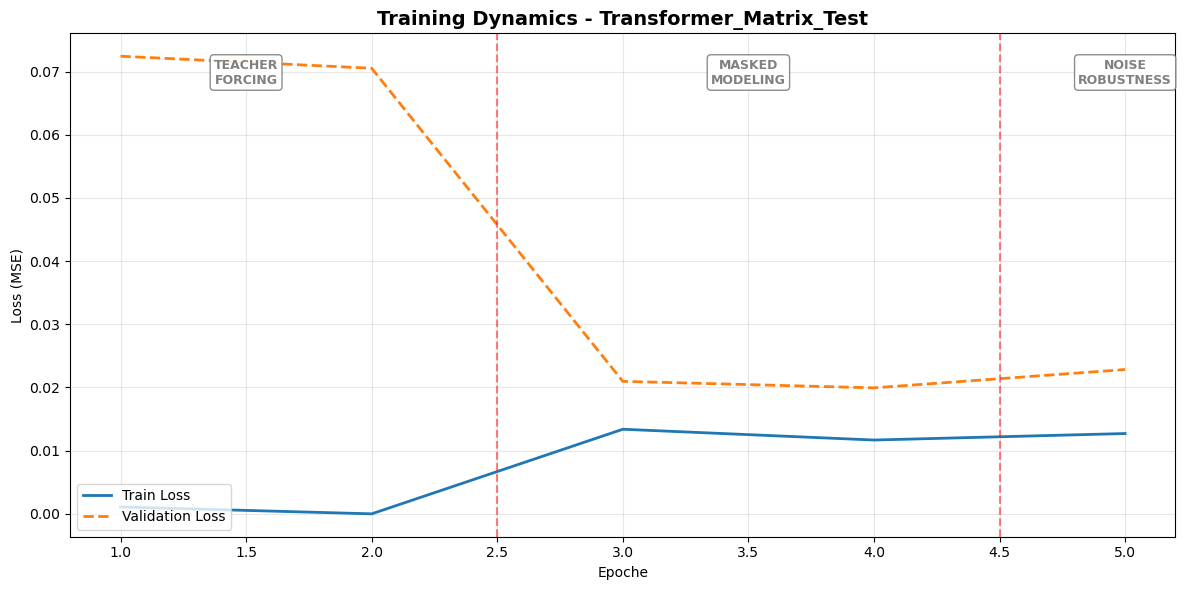

Grafico salvato in: data/plots/training/loss_Transformer_Matrix_Test.png
Generazione predizioni per 1000 step...


/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


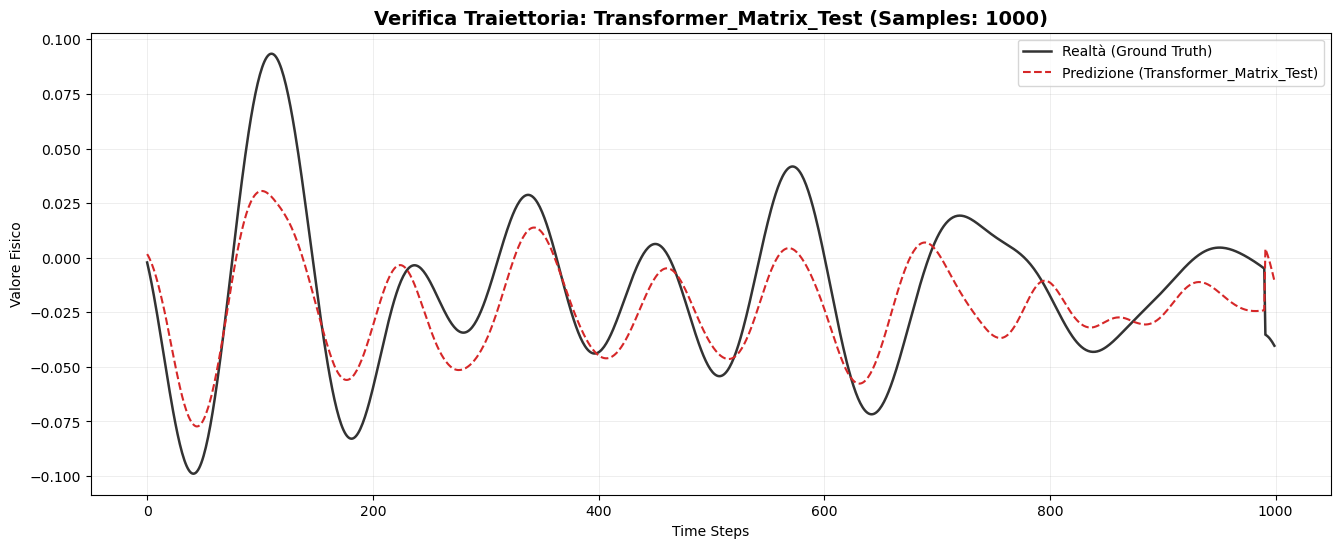

Grafico salvato in: data/plots/predictions/pred_Transformer_Matrix_Test.png
Recupero mappe di attenzione...


/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


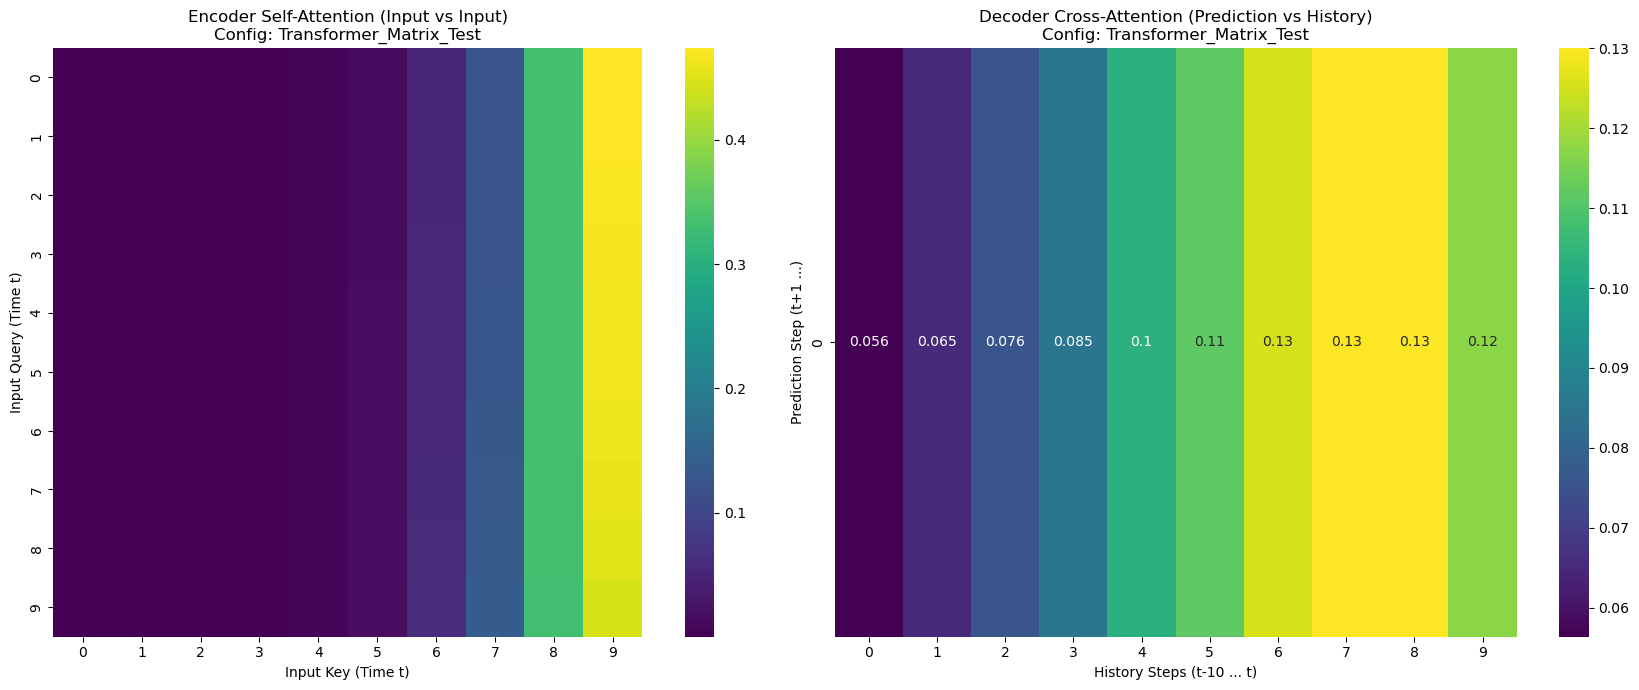

Grafico combinato salvato in: data/plots/attentions/att_Transformer_Matrix_Test.png


'for transformer_config in TRANSFORMER_CONFIGS:\n    run_curriculum_experiment(transformer_config)'

In [ ]:
exp_manager = ExperimentManager(base_path="data")

def run_curriculum_experiment(config):
    print(f"\n--- Avvio Esperimento: {config['name']} ---")
    
    # 1. Caricamento Dati
    dm = QuantumDataManager(config)
    
    if not hasattr(dm, 'X_train'):
        dm.load_and_process(num_rows=250000)

    input_dim = dm.X_train.shape[-1] 
    train_ds, val_ds = dm.get_tf_datasets()
    
    print(f"Dati caricati. Input features: {input_dim}")

    # 2. Modello
    model = QuantumTransformer(
        input_dim=input_dim,
        seq_len=config['window_size'],
        d_model=config['embed_dim'],
        num_heads=config['num_heads'],
        d_ff=config['ff_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    history = train_with_curriculum(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=config['total_epochs'],
        tf_epochs=config['tf_epochs'],
        mm_epochs=config['mm_epochs'],
        nr_epochs=config['nr_epochs']
    )
    
    # 4. Salvataggio e Plotting
    print("\n--- Salvataggio Risultati ---")
    exp_manager.save_model_artifacts(model, history, config['name'])
    
    print("\n--- Generazione Grafici ---")
    exp_manager.plot_training_phases_detailed(history, config['name'])
    exp_manager.plot_trajectory_check(model, dm, config['name'])
    exp_manager.plot_attention_map(model, dm, config['name'])
    
    return model, history

run_curriculum_experiment(TRANSFORMER_CONFIGS[0])

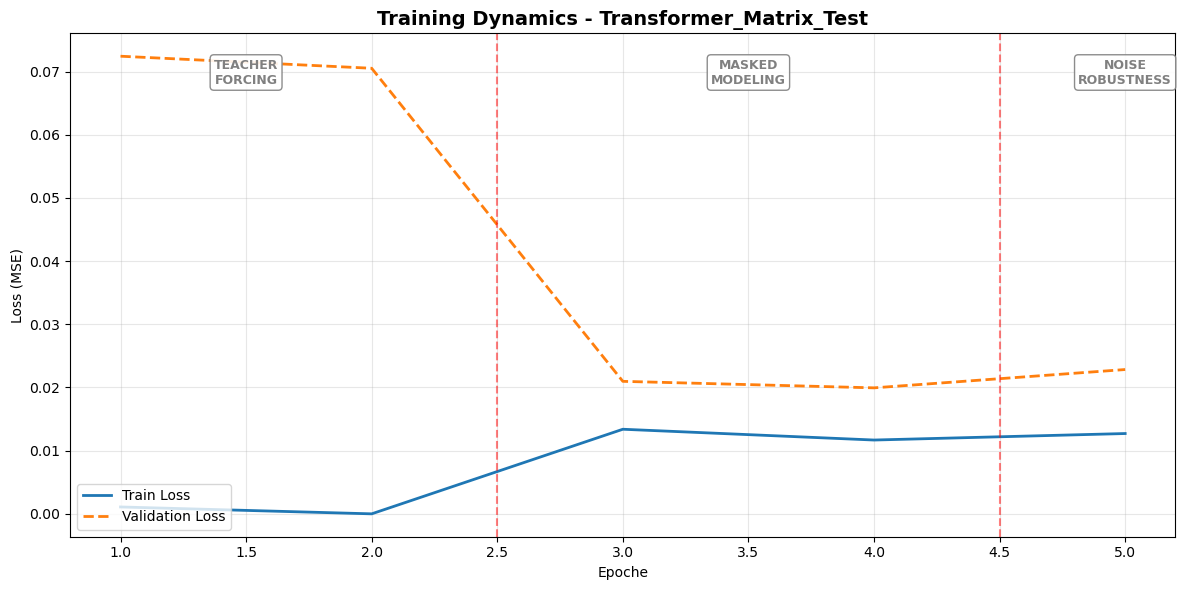

Grafico salvato in: data/plots/training/loss_Transformer_Matrix_Test.png
Dataset caricato: (400400, 56)
Traiettorie individuate: 400
[Transformer_Matrix_Test] Dataset caricato. Train shape: (317120, 10, 55)
Trovato file pesi: data/weights/Transformer_Matrix_Test.weights.h5
Inizializzazione pesi (Dummy Call)...


/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'quantum_transformer_19', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Pesi caricati correttamente.
Generazione predizioni per 1000 step...


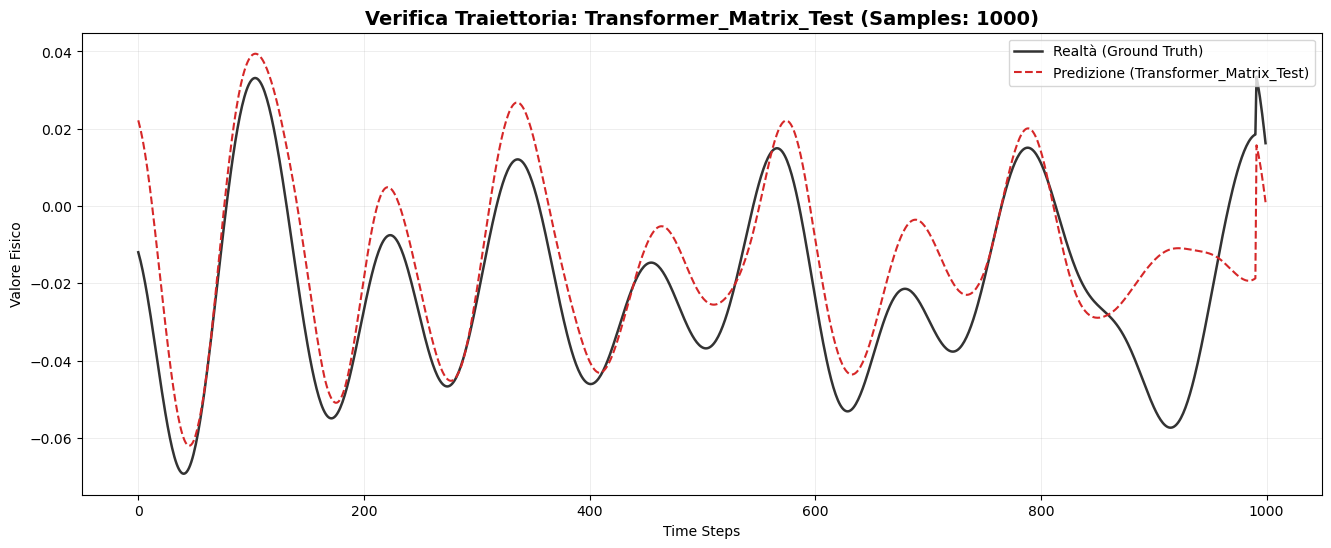

Grafico salvato in: data/plots/predictions/pred_Transformer_Matrix_Test.png
Recupero mappe di attenzione...


/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


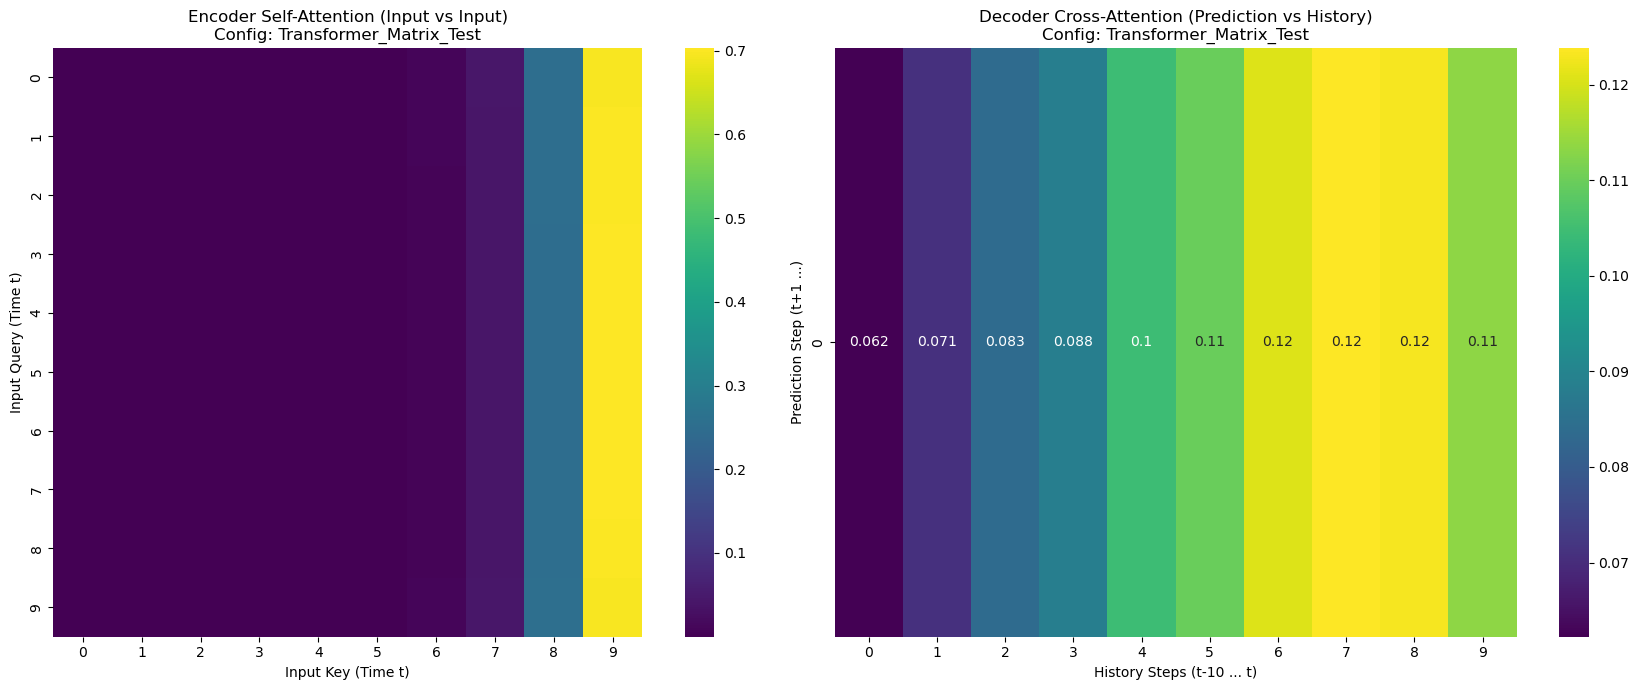

Grafico combinato salvato in: data/plots/attentions/att_Transformer_Matrix_Test.png


In [50]:
import pandas as pd

# 1. Configurazione
config = TRANSFORMER_CONFIGS[0]
exp_manager = ExperimentManager()

# 2. Carica History
history_df = pd.read_csv(f"data/history/{config['name']}_history.csv")
# Converti in dict per la funzione plot
history_dict = history_df.to_dict(orient='list')

# 3. Plot History
exp_manager.plot_training_phases_detailed(history_dict, config['name'])

# 4. Inizializza Data Manager e Modello (necessari per la traiettoria)
dm = QuantumDataManager(config)
dm.load_and_process() # Carica i dati per avere X_test e lo scaler
input_dim = dm.X_train.shape[-1]

model = QuantumTransformer(
    input_dim=input_dim,
    seq_len=config['window_size'],
    d_model=config['embed_dim'],
    num_heads=config['num_heads'],
    d_ff=config['ff_dim'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
)

# 5. Carica Pesi
exp_manager.load_model_weights(model, config['name'])

# 6. Plot Traiettoria
exp_manager.plot_trajectory_check(model, dm, config['name'])

# 7. Plot Attention Map
exp_manager.plot_attention_map(model, dm, config['name'])